## Phase estimation

The phase estimation algorithm is a solution to a rather specific problem. However, similarly to the QFT and Grover's search algorithm, it turns out to be useful as a building block to several other algorithms to solve more general and important problems.

Suppose we have a unitary operator $\hat{U}$ operating on $n$-qubits, with a known eigenstate$^1$ $| u \rangle$ and an associated unknown eigenvalue $e^{i\phi}$, where $0 \leq \phi < 2\pi$. We want to find the eigenvalue, which means finding phase $\phi$ with $m$-bits of precision.


We might try to prepare $n$ qubits in the state $|u\rangle$ and carry out the unitary transformation $\hat{U}$ on them:


<img src="img/pe1.PNG" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 


$^1$: An eigenstate is a quantum mechanical state whose wave function is an eigenvector that corresponds to a physical quantity.

**Question**: is there a measurement on the bits which will give us information about the phase $\phi$?

The answer is **no**: $\hat{U}$ just produces an overall phase on the state, with no observable consequences.

In [3]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, compile

from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram

from math import pi
import matplotlib.pyplot as plt

In [4]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [37]:
def qftransform (circuit, qr, swap = True,n=0):
    if n==0:
        n = qr.size
    for i in range(n-1, -1, -1):
        circuit.barrier()
        circuit.h(qr[i])
        for j in range (i-1, -1, -1):
            r = 2**(i-j+1)
            circuit.cu1((2*pi/r), qr[j], qr[i])
    circuit.barrier()
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
            
def inverse_qftransform (circuit, qr, swap = True,n=0):
    if n==0:
        n = qr.size
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
    for i in range(0, n, 1):
        circuit.barrier()
        for j in range (0, i, 1):
            r = 2**(i-j+1)
            circuit.cu1((-2*pi/r), qr[i], qr[j])
        circuit.h(qr[i])
    circuit.barrier()

### Phase estimation algorithm

The first part of the phase estimation algorithm consists in a paralell application of the phase kickback technique detailed above, to successive powers of $U$:

<img src="img/pk3.PNG" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center"> 

The complete phase estimation procedure is as follows:

1. Prepare the $t$-bit control register in state $|0 \rangle$, and the target register in state $|u\rangle$ (eigenstate of $U$);

2. Perform Hadamards on the control bits.

3. Apply a controlled-$\hat{U}^{2^j}$, from the $j$th control bit onto the n target bits for each of the control q-bits in succession.

4. Perform an **inverse** Fourier transform on the $t$ control bits and measure them in the computational basis. The measured bit values $\phi_1, \cdots, \phi_n$ give an estimate of the phase $\phi \approx 0.\phi_1 \cdots \phi_n$, or $\phi \approx \frac{\phi_1}{2}+ \cdots + \frac{\phi_n}{2^n}$.

**Task**: Implement the phase estimation technique to estimate the eigenvalues of a single bit unitary

$$R_z = \begin{pmatrix}
e^{-i\pi/4} & 0\\ 
0 & e^{i\pi/4}
\end{pmatrix}$$

1. For eigenstate $|1\rangle$.

2. What is the result for eigenstate $|0 \rangle$?

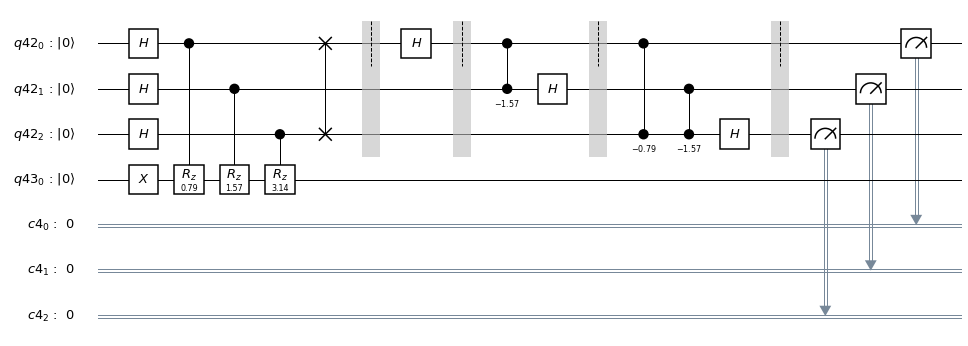

In [38]:
n=3
qctrl = QuantumRegister(n)
qtrg= QuantumRegister(1)
cr = ClassicalRegister(n)

qc = QuantumCircuit(qctrl, qtrg, cr)

qc.h(qctrl)
qc.x(qtrg)

qc.crz(pi/4, qctrl[0], qtrg[0])

qc.crz(pi/2, qctrl[1], qtrg[0])

qc.crz(pi, qctrl[2], qtrg[0])

inverse_qftransform(qc, qctrl)

qc.measure(qctrl, cr)

qc.draw(output='mpl')

simulation: 

 {'010': 60, '100': 16, '001': 375, '111': 58, '000': 422, '110': 29, '101': 13, '011': 27}


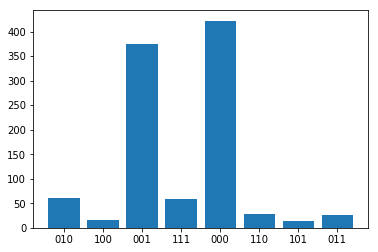

In [39]:
execute_locally(qc)

The bit string `001` equates to $\phi \approx 1/8$, which makes the eigenvalue $e^{2\pi i\phi} = e^{\pi i/4}$.

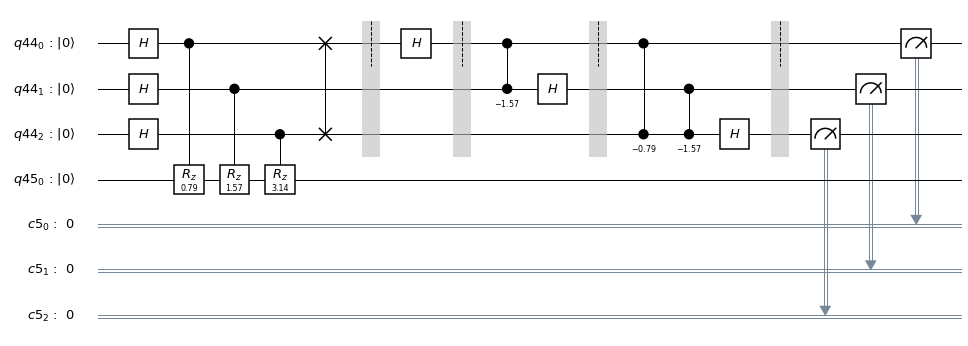

In [40]:
n=3
qctrl = QuantumRegister(n)
qtrg= QuantumRegister(1)
cr = ClassicalRegister(n)

qc = QuantumCircuit(qctrl, qtrg, cr)

qc.h(qctrl)

qc.crz(pi/4, qctrl[0], qtrg[0])

qc.crz(pi/2, qctrl[1], qtrg[0])

qc.crz(pi, qctrl[2], qtrg[0])

inverse_qftransform(qc, qctrl)

qc.measure(qctrl, cr)

qc.draw(output='mpl')

simulation: 

 {'010': 27, '100': 31, '001': 53, '111': 408, '000': 388, '110': 46, '101': 28, '011': 19}


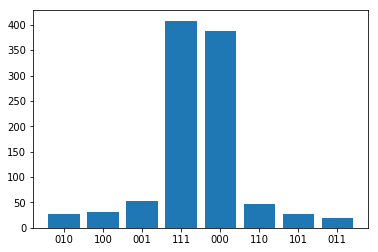

In [41]:
execute_locally(qc)

The bit string `001` equates to $\phi \approx 1/2 + 1/4 + 1/8$, which makes the eigenvalue $e^{2\pi i\phi} = e^{7\pi i /4} = e^{-\pi i/4}$.

**TASK**

Implement a function `phase_est(qc, theta, phi, lambda, n)` to create a phase estimation circuit in `qc` with `n` bits of precision, for a general single-qubit operation

$$
u_3(\theta, \phi, \lambda) = 
	    \begin{pmatrix}
        \cos{(\theta/2)} & -e^{i\lambda}\sin{(\theta/2)}\\ 
        e^{i\phi}\sin{(\theta/2)} & e^{i(\lambda + \phi)}\cos{(\theta/2)}
        \end{pmatrix}
$$

Note: To test the implementation, `qc` should be prepared with an eigenstate of $u_3$ before calling `phase_est`.

In [94]:
def phase_est(qc,qr,theta,phi,lamb,n):

    
    for i in range(n) :
        qc.h(qr)
        for j in range (2**i):
            qc.cu3(theta,phi,lamb,qr[i],qr[n])
            
    inverse_qftransform(qc,qr,n=n)



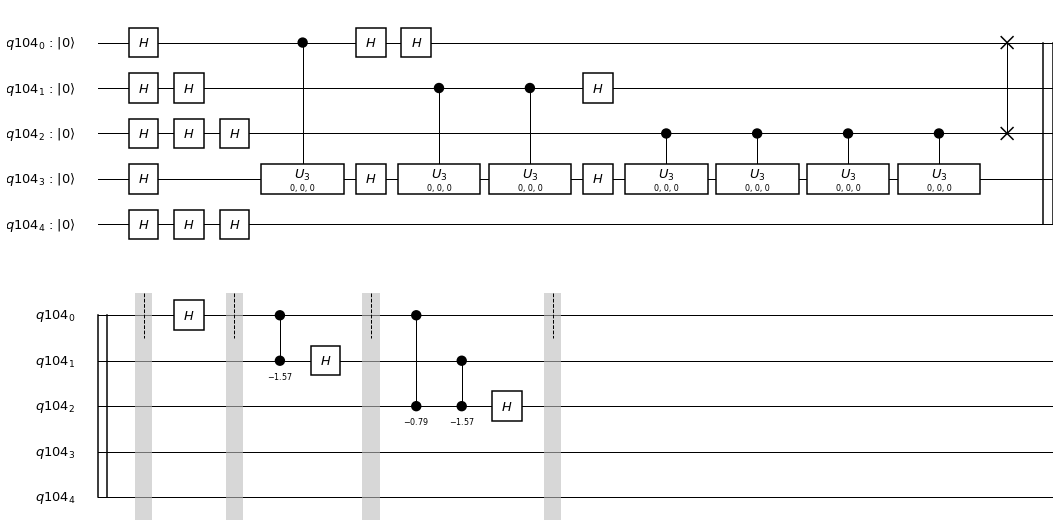

In [96]:
N=5

qr=QuantumRegister(N)

qc = QuantumCircuit(qr)

phase_est(qc,qr,0,0,0,3)

qc.draw(output='mpl')


## Arithmetic in quantum circuits

Arithmetic operations are constitute the basis of many quantum numerical algorithm, such as Shor's factorization algorithm. However, because any unitary operation is reversible (unlike classical logic gates such as `AND` or `OR`), elementary arithmetic operations such as addition, multiplication and exponentiation cannot be directly deduced from their classical Boolean counterparts.

It has been shown that reversible networks require some additional memory for storing intermediate results. Hence, the "art" of building quantum arithmetic networks is often reduced to optimizing the trade-off between size of auxiliary memory, and complexity of computational steps required to complete a given operation in a reversible way.

### Plain adder

Let's start with one of the most basic arithmetic operations: addition. More specifically, we will admit an operation that takes to registers $|a \rangle$ and $|b \rangle$, and outputs the register sum to register $|b \rangle$, i.e.

$$|a\rangle |b\rangle \rightarrow |a\rangle |a+b\rangle$$

Since one can reconstruct the input $(a,b)$ from the output $(a, a+b)$, there is no loss of information.

**Note**: To prevent overflows, register b should be encoded in $n+1$ qubits, where $n$ is the number of qubits in register $a$.

We will follow the steps detailed for the plain adder in section **A.** of

[Vedral, Vlatko, Adriano Barenco, and Artur Ekert. "Quantum networks for elementary arithmetic operations." Physical Review A 54.1 (1996): 147.](https://arxiv.org/abs/quant-ph/9511018)

The algorithm is built from `carry` and `sum` blocks:

<img src="img/add_blocks.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center">

And $n-1$ ancilla qubits, where $n$ is the size of register $|a\rangle$.

<img src="img/adder.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="900 px" align="center">

**Note**: a black bar on the left side of each sub block means the operations inside the block are in reverse order.

**TASK**

Implement a function `adder(qc, a, b, c)` to add quantum registers $|a\rangle$ to register $|b\rangle$, using the register $|c\rangle$ as ancilla.

In [92]:
def carry (qc,cin,a,b,cout):
    qc.ccx(a,b,cout)
    qc.cx(a,b)
    qc.ccx(cin,b,cout)

def carryinv(qc,cin,a,b,cout):
    qc.ccx(cin,b,cout)
    qc.cx(a,b)
    qc.ccx(a,b,cout)
    
def soma(qc,cin,a,b):
    qc.cx(a,b)
    qc.cx(cin,b)

def adder(qc,a,b,c):
    n=a.size
    for i in range(n-1):
        carry(qc,c[i],a[i],b[i],c[i+1])
        
    carry(qc,c[i],a[i],b[i],b[i+1])
    qc.cx(c[i],b[i])
    
    for i in range(n-2,-1,-1):
        
        carryinv(qc,c[i],a[i],b[i],c[i+1])
        soma(qc,c[i],a[i],b[i])
        
        

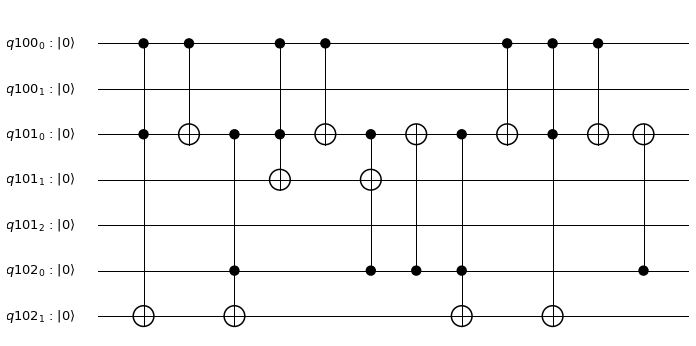

In [93]:
n=2
a=QuantumRegister(n,'a')
b=QuantumRegister(n+1,'b')
c=QuantumRegister(n,'c')
qc=QuantumCircuit(a,b,c)
cbits=ClassicalRegister(n+1)

adder(qc,a,b,c)
qc.draw(output='mpl')

### Plain subtracter

**TASK**

Build a subtracter from the plain adder algorithm, using the equivalence

$$a-b \equiv \neg (\neg a+b)$$

Or just reverting the circuit for the plain adder.